# Descriptive Figures

This notebook reads in the processed data curated by from PubMed Central and builds some descriptive figures about it.

In [35]:
### We start by importing a lot of important python packages and loading the csv into a pandas dataframe
from __future__ import print_function #We need this for something...

import datetime as dt
from IPython.display import display
import itertools as it
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import date2num
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import sys

# Load the autoreload extension so the following
# scripts are automatically re-loaded when you
# run the notebook
# (This isn't super important for the final product
# but is very valuable to include during development)
%load_ext autoreload
%autoreload 2

# Import local visualisation scripts
sys.path.append('../scripts')
from das_visualisations import pubs_over_time, get_mandate_dates

# Set style for figures
sns.set(style='white', font_scale = 1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


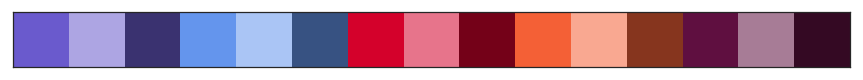

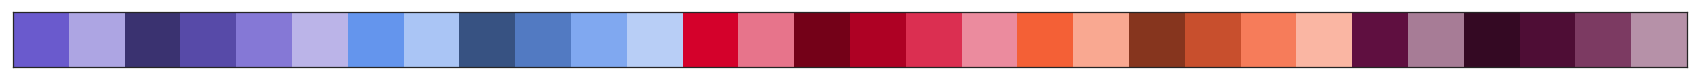

In [2]:
# Define colour palette for seaborn plotting

# The main colour palette is linked at
# https://coolors.co/6a5acd-6495ed-d4012b-f46036-5f0f40
# The light colour palette was created by taking the alternate 
# shade that was 5 steps above the main colour and is linked at
# https://coolors.co/ada5e3-aac5f5-e7748b-f9a891-a77c96
# The dark colour palette was created by taking the alternate 
# shade that was 5 steps below the main colour and is linked at
# https://coolors.co/3a3270-375282-740118-86351e-a77c96

palette=['#6A5ACD', '#ada5e3', '#3a3270',
         '#6495ED', '#aac5f5', '#375282',
         '#d4012b', '#e7748b', '#740118',
         '#f46036', '#f9a891', '#86351e',
         '#5f0f40', '#a77c96','#340923']
sns.set_palette(palette)
sns.palplot(sns.color_palette())

# We need to make a more nuanced one though that works for the 
# 5 das classes though :)
# Lets keep the first 3 colours the same, and then add in 5 more
# for the different classes.
# The 3rd colour will correspond to das class 0, and then the
# 4th - 8th will be classes 1 - 5.
# The main colour palette is linked at
# https://coolors.co/6a5acd-6495ed-d4012b-f46036-5f0f40
# The light colour palette was created by taking the alternate 
# shade that was 5 steps above the main colour and is linked at
# https://coolors.co/ada5e3-aac5f5-e7748b-f9a891-a77c96
# The dark colour palette was created by taking the alternate 
# shade that was 5 steps below the main colour and is linked at
# https://coolors.co/3a3270-375282-740118-86351e-340923


# CLASS 1: https://coolors.co/574aa8-527ac2-ae0124-c84f2d-4e0d35
# CLASS 2: https://coolors.co/6a5acd-6495ed-d4012b-f46036-5f0f40
# CLASS 3 (2): https://coolors.co/8578d6-80a8f0-db2f51-f67c5a-7c3a62
# CLASS 4: https://coolors.co/a096df-9cbbf3-e35d78-f8997f-996685
# CLASS 5 (3): https://coolors.co/bbb4e8-b8cef6-eb8b9e-fab6a3-b691a8

palette_extended=['#6A5ACD', '#ada5e3', '#3a3270', '#574aa8', '#8578d6', '#bbb4e8', 
                  '#6495ED', '#aac5f5', '#375282', '#527ac2', '#80a8f0', '#b8cef6', 
                  '#d4012b', '#e7748b', '#740118', '#ae0124', '#db2f51', '#eb8b9e', 
                  '#f46036', '#f9a891', '#86351e', '#c84f2d', '#f67c5a', '#fab6a3', 
                  '#5f0f40', '#a77c96','#340923', '#4e0d35', '#7c3a62', '#b691a8']

sns.set_palette(palette_extended)
sns.palplot(sns.color_palette())

## 0 Read in the data

### 0.0 Read in the data for the individual articles

Note that the data is sufficiently large that you'll need the `low_memory=False` option when reading in the data to pandas.

Here's a list of the columns in the dataset. Each row is a paper.

* `pmid`: pubmed id
* `pmcid`: pubmed central id
* `doi`: digital object identifier
* `publisher_id`: publisher specific identifier
* `journal`: name of journal
* `journal_domain`:
* `journal_field`:
* `journal_subfield`:
* `n_authors`: number of authors
* `is_plos`: True if PLOS journal, otherwise False
* `is_bmc`: True if BMC journal, otherwise False
* `title`: paper title
* `n_references_tot`: currently set to zero, ignore for now it will come with the next export
* `n_references`: 
* `has_das`: True if article has a data availability statement, otherwise False
* `das_encouraged`: article published when the journal had an encouraged das policy
* `das_required`: article published when the journal had a required das policy
* `das`: text of data availability statement where present
* `p_year`: publication year
* `p_month`: publication month (def. to 6 if absent)
* `has_month`: True if month included in publication date, False otherwise 
* `n_cit_2`: number of citations received after 2 years from publication (counting from the month)
* `n_cit_3`: number of citations received after 3 years from publication (counting from the month)
* `n_cit_5`: number of citations received after 5 years from publication (counting from the month)
* `n_cit_tot`: total number of citations
* `h_index_min`: minimum h-index of the authors at publication time
* `h_index_max`: maximum h-index of the authors at publication time
* `n_index_mean`: mean h-index of the authors at publication time
* `n_index_median`: median h-index of the authors at publication time
* `das_class`: das classified as ????
* `das_class_simple`: das classified as ????
* `j_lower`: name of the journal all in lower case

In [3]:
df = pd.read_csv('../dataset/exports/export_full_merged_20190221.csv', low_memory=False, sep=';', index_col=0)

### 0.1 Convert the date

`p_date`: We have the year and month that the aricle was published in this dataset.
In order to re-format them into a datetime we'll set the day as the 15th of the month.

In [4]:
# Create a column for the publication date.
# Note that we're setting the dates to the 15th of the publication month

df['year'] = df['p_year']
df['month'] = df['p_month']
df['day'] = 15
df['p_date'] = pd.to_datetime(df.loc[:, ['year', 'month', 'day']])

### 0.2 Remap the categories from 5 groups to 3

We had two coding schemes, one that grouped the articles into 5 categories and the other into 3.
One of the originally hypothesised groups in the 5 categories had very few articles so here we collapse the ratings into just 3 categories instead.


In [5]:
# Remap the categories from 5 to 3

# 3 to 1 (category 3 becomes 1)
# 4 to 3
# 5 to 3
# 2 stays to 2

df.loc[df['das_class']==3, 'das_class'] = 1
df.loc[df['das_class']==4, 'das_class'] = 3
df.loc[df['das_class']==5, 'das_class'] = 3


### 0.3 Take a look at a few class 3 das to verify that they've been classified accurately


In [12]:
for title, das in df.loc[df['das_class']==3, ['title', 'das']].values[1:10000:1000]:
    print ('TITLE: {}'.format(title))
    print ('DAS: {}'.format(das))
    print ("\n\n==============")

TITLE: Very-Heavy Precipitation in the Greater New York City Region and Widespread Drought Alleviation Tied to Western US Agriculture
DAS: All analysis R code and summarized datasets are publicly accessible via Github (github.com/wanderswest/IRRIG).


TITLE: VariantMetaCaller: automated fusion of variant calling pipelines for quantitative, precision-based filtering
DAS: The VariantMetaCaller software and the artificial sequencing data sets supporting the results of this article is freely available at http://bioinformatics.mit.bme.hu/VariantMetaCaller/. The real sequencing data set is available (after registration) as part of a public Illumina BaseSpace project: “HiSeq 2000: TruSeq PCR-Free (Platinum Genomes)” at https://basespace.illumina.com/home/index.


TITLE: Unsupervised correction of gene-independent cell responses to CRISPR-Cas9 targeting
DAS: All data generated or analysed during this study are included in this published article and its supplementary information files. sgRNAs r

### 0.4 Read in the dates that the policies were put into place

This data was curated by Iain and Isla from a few different sources into a handy dandy csv file.
It lists the dates that each journal *required* or *encouraged* a data availability statement in the submitted articles.

In [26]:
df_policies = pd.read_csv('../resources/Dates-of-Journal-Data-Availability-Statement-Policies.csv', sep=';')

# Convert the dates to datetime
df_policies['Required'] = pd.to_datetime(df_policies['Required'])
df_policies['Encouraged'] = pd.to_datetime(df_policies['Encouraged'])

# Convert PloS to PLOS
df_policies.loc[df_policies['Group']=='PloS', 'Group'] = 'PLOS'
df_policies

,Group,Journal,Required,Encouraged
0,BMC series,bmc research notes,2015-05-01,2011-08-01
1,BMC series,All,2015-05-01,2012-10-01
2,BMC,agriculture & food security,2015-05-01,2011-11-01
3,BMC,annals of clinical microbiology and antimicrob...,2015-05-01,2011-11-01
4,BMC,biological research,2015-05-01,2013-11-01
5,BMC,cell & bioscience,2015-05-01,2011-12-01
6,BMC,cell communication and signalling,2015-05-01,2012-01-01
7,BMC,cilia,2015-05-01,2012-11-01
8,BMC,clinical epigenetics,2015-05-01,2011-12-01
9,BMC,extreme physiology & medecine,2015-05-01,2012-01-01


## 1.0 Plot the number of papers over time

Look to see how many papers there are in pubmed central over time, separated by publisher (PLOS and BMC).

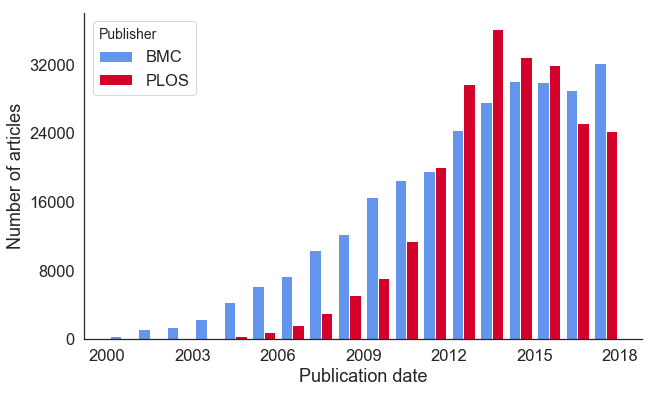

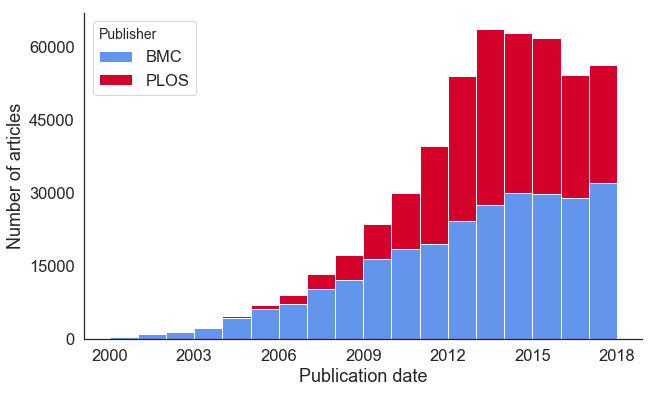

In [36]:
# Stack the data you want to visualise
pub_date_data = [df.loc[df['is_bmc']==True, 'p_date'],
                 df.loc[df['is_plos']==True, 'p_date']]

# Get colors for bmc and plos
color_list = [palette[3], palette[6]]

# Label the data frames
label_list = ['BMC', 'PLOS']

# Legend title
legend_title = 'Publisher'

# Plot data between 2000 and 2019
year_range = (2000, 2019)

# Lets make one stacked and one regular bar histogram
# for all publications between 2000 and 2019 split by publisher
for hist_type in ['bar', 'barstacked']:

    # Name the figure
    output_fname = '../figures/PubsOverTime_All_ByPublisher_2000to2019_{}.png'.format(hist_type.capitalize())

    # Make the figure
    fig, ax = pubs_over_time(pub_date_data,
                             color_list=color_list,
                             label_list=label_list,
                             legend_title=legend_title,
                             year_range=year_range,
                             hist_type=hist_type,
                             output_fname=output_fname)

## 2.0 Show the number of publications with (and without) data availability statements over time

This section makes plots for 3 groups of data:

* BMC articles on their own
* PLOS articles on their own
* PLOS and BMC combined

It makes the plots across two date ranges:

* 2000 to 2019
* 2012 to 20019

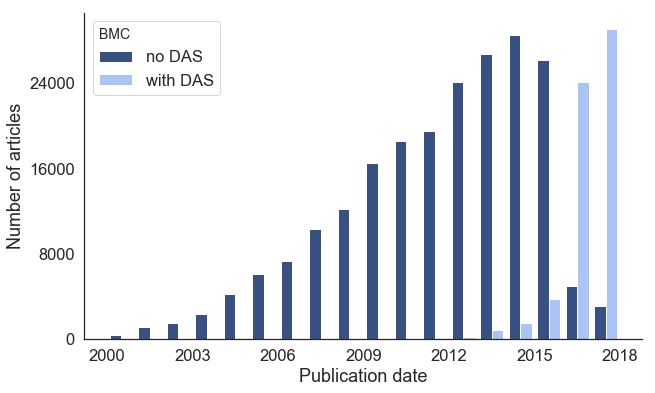

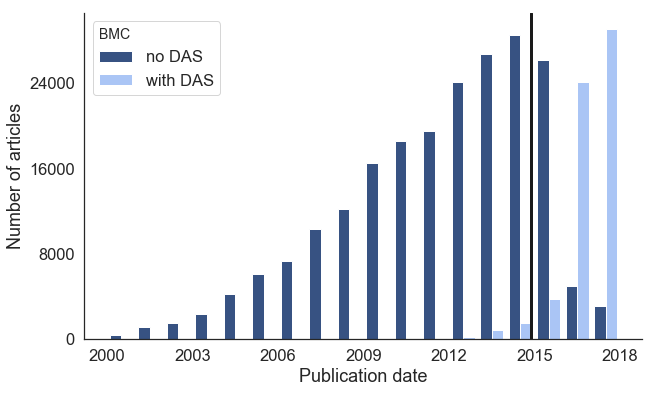

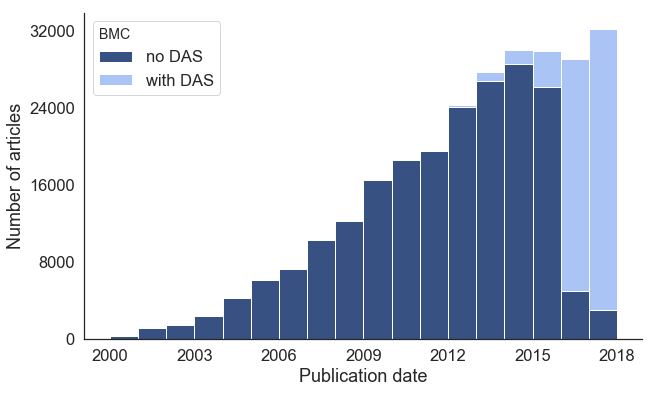

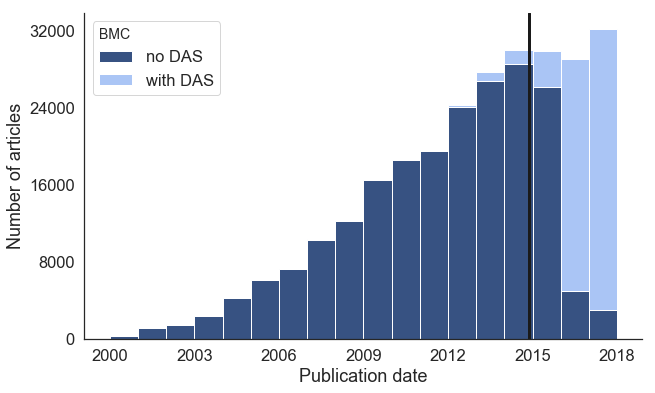

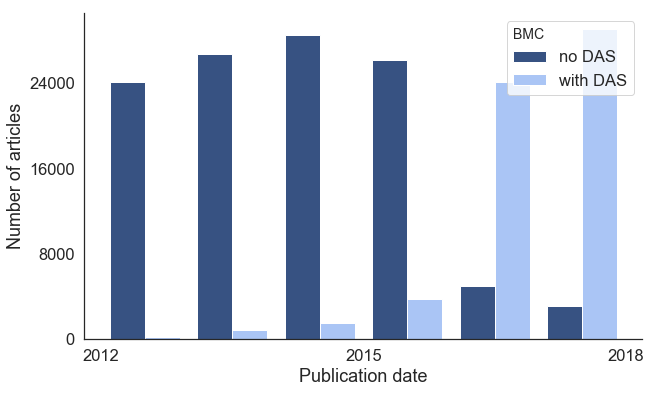

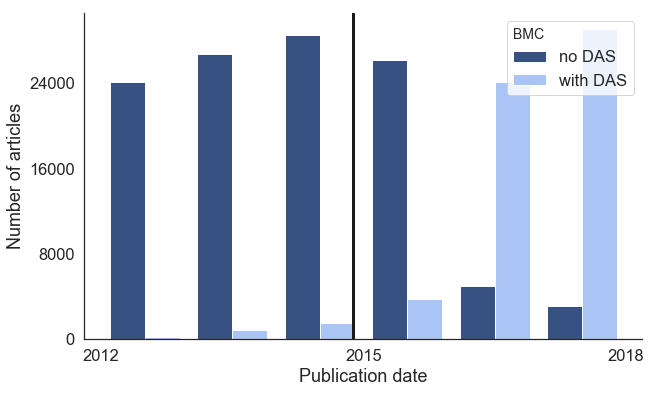

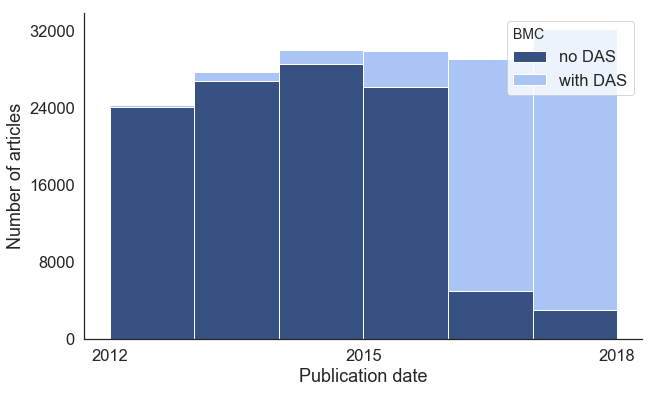

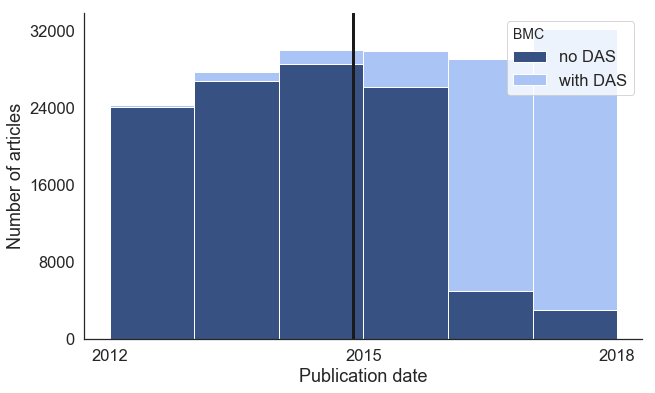

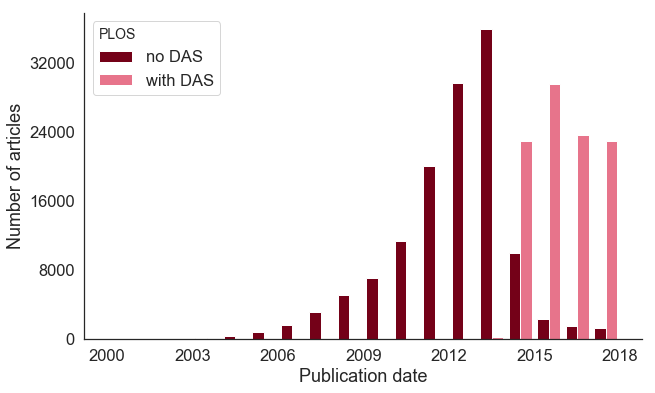

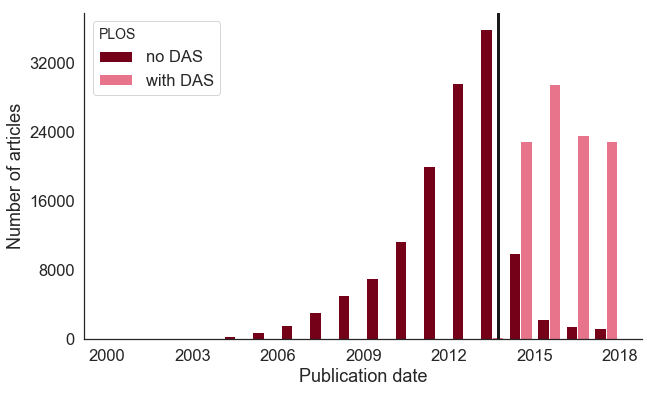

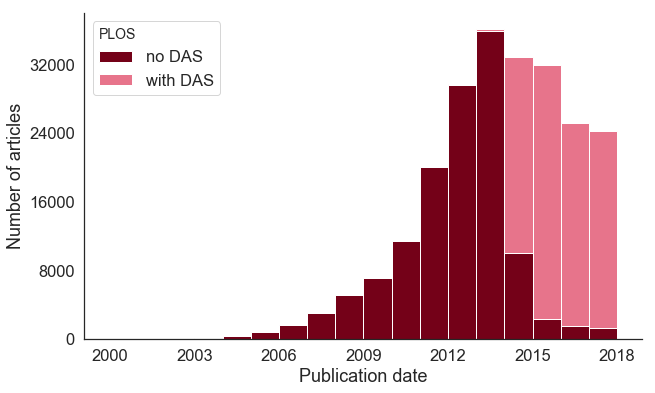

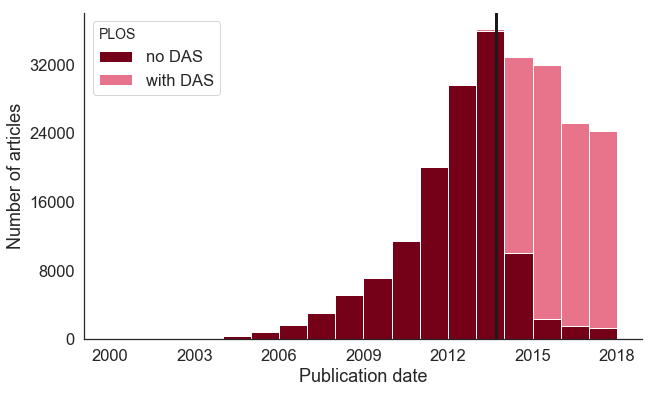

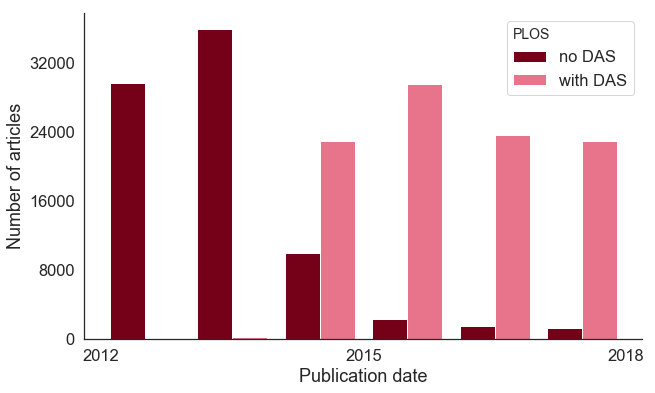

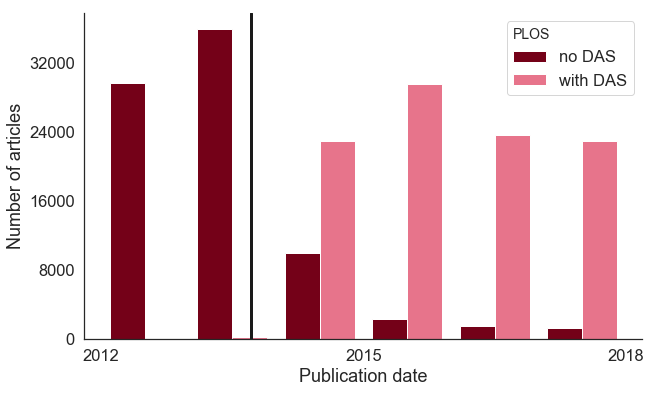

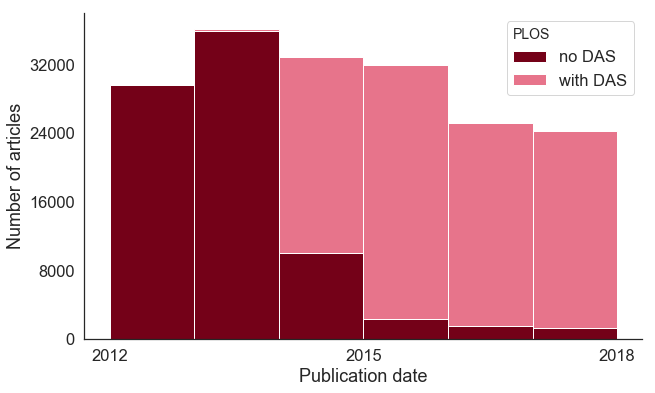

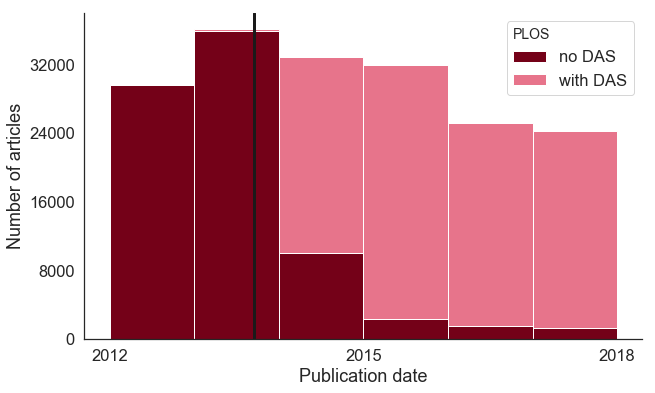

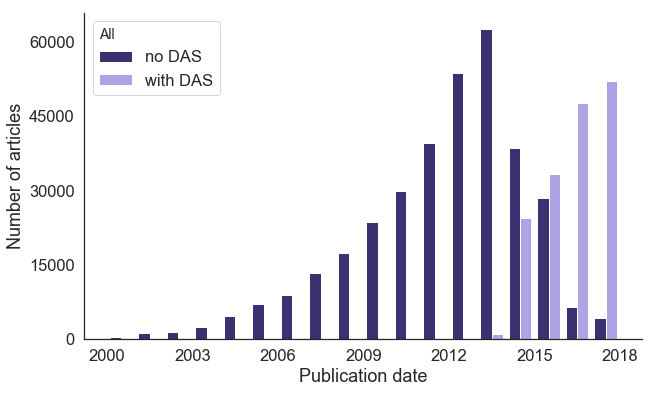

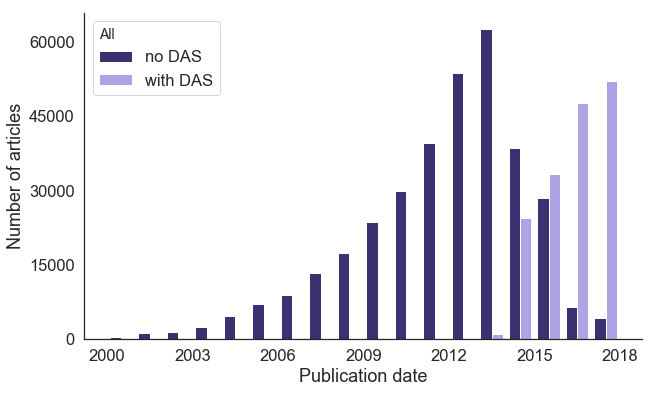

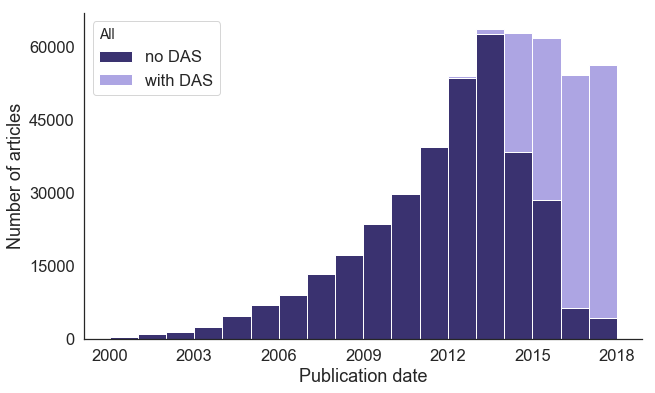

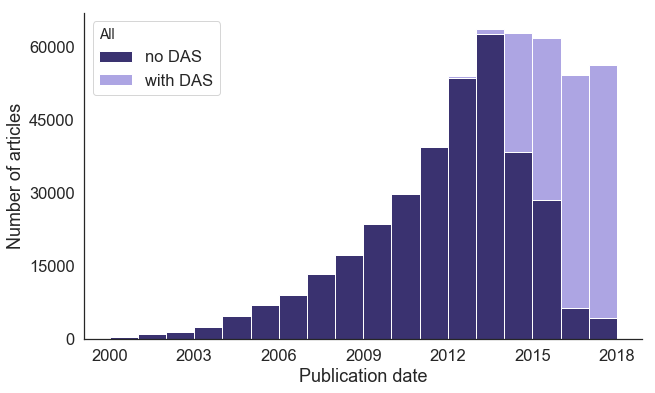

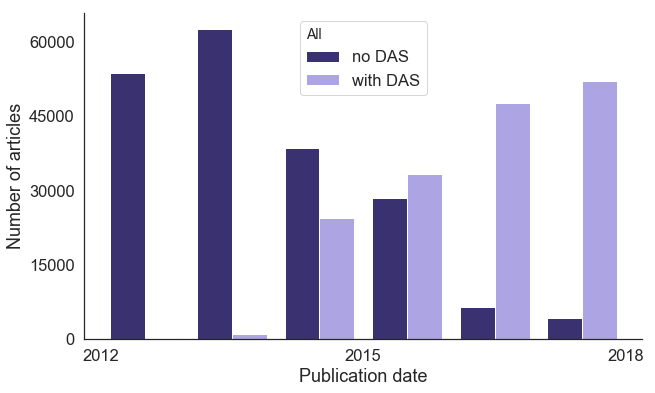

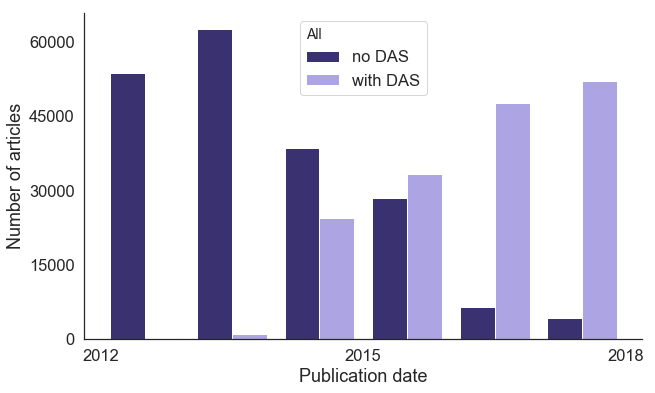

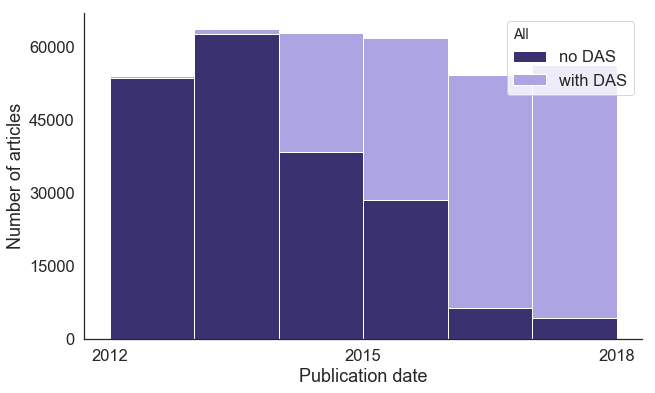

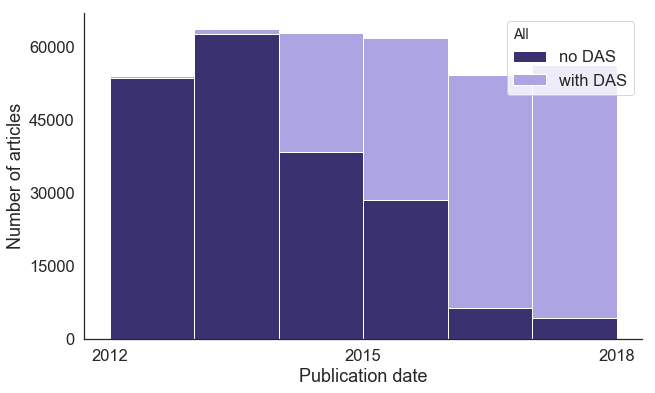

In [45]:
# Define five masks:
# - with and without DAS
das_mask = df['has_das']==True
nodas_mask = df['has_das']==False
# - bmc, plos and combined
bmc_mask = df['is_bmc']==True
plos_mask = df['is_plos']==True
combined_mask = (bmc_mask) | (plos_mask)

# Publisher dictionary
publisher_dict = { 'BMC' : (bmc_mask, 1), 'PLOS' : (plos_mask, 2), 'All' : (combined_mask, 0)}

# Plot the data over two year ranges
year_dict = { 'Dates_2000to2019' : (2000, 2019), 'Dates_2012to2019' : (2012, 2019) }

for ((publisher, (publisher_mask, color_counter)),
     (year_str, year_range)) in it.product(publisher_dict.items(), year_dict.items()):

    # Stack the data you want to visualise
    pub_date_data = [df.loc[(publisher_mask) & (nodas_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das_mask), 'p_date']]

    # Label the data frames
    label_list = [ 'no DAS', 'with DAS']

    # Get the right colours
    color_list = [palette[(color_counter*3) + 2],
                  palette[(color_counter*3) + 1]]

    # Set up the legend
    legend_title = publisher

    # Get the required and encouraged dates
    required_date, encouraged_date = get_mandate_dates(df_policies,
                                                       publisher=publisher,
                                                       journal='All')

    date_line_dict = {'NoDateLine': (None, None),
                      'DateLine' : (required_date, encouraged_date)}
    
    # Lets make one stacked and one regular bar histogram
    # and one version with and one without the datelines
    for (hist_type,
         (date_line_str, (required_date, encouraged_date))) in it.product(['bar', 'barstacked'],
                                                                          date_line_dict.items()):

        output_fname = os.path.join('..',
                                    'figures',
                                    year_str,
                                    date_line_str,
                                    hist_type,
                                    'PubsOverTime_{}_ByDas.png'.format(publisher))

        # Make the figure
        fig, ax = pubs_over_time(pub_date_data,
                                 color_list=color_list,
                                 label_list=label_list,
                                 legend_title=legend_title,
                                 year_range=year_range,
                                 hist_type=hist_type,
                                 output_fname=output_fname,
                                 required_date=required_date,
                                 encouraged_date=encouraged_date)
        plt.show()
        plt.close()

## 3.0 Show the number of publications split by the three DAS classes (and no DAS) over time

This section makes plots for 3 groups of data:

* BMC articles on their own
* PLOS articles on their own
* PLOS and BMC combined

It makes the plots across two date ranges:

* 2000 to 2019
* 2012 to 20019

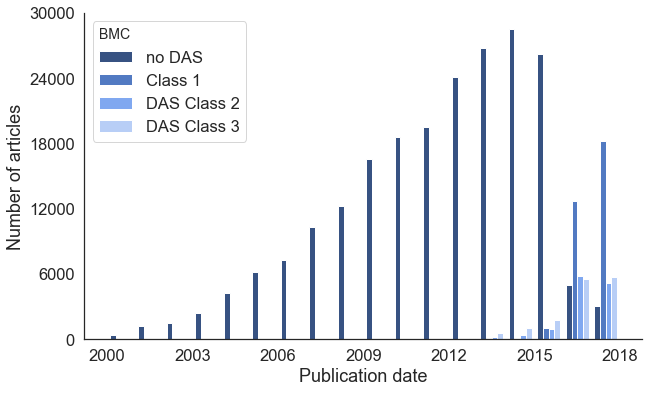

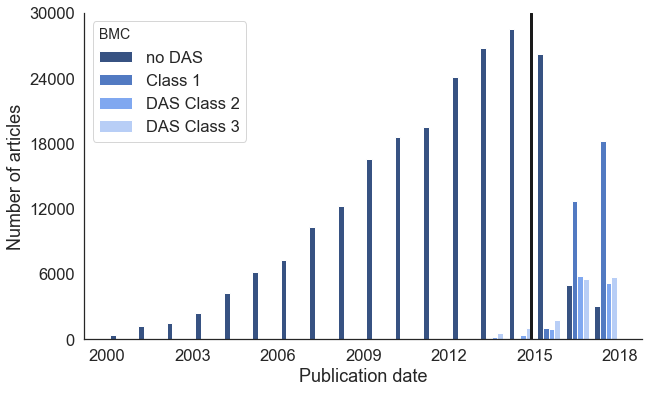

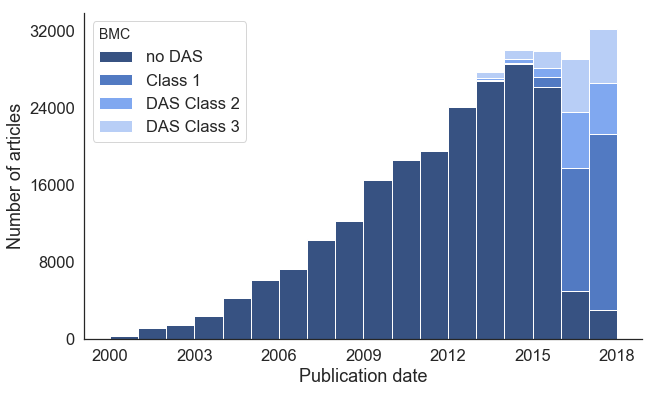

In [ ]:
# Define seven masks:
# - the three das classes and no DAS
das1_mask = df['das_class']==1
das2_mask = df['das_class']==2
das3_mask = df['das_class']==3
nodas_mask = df['has_das']==False
# - bmc, plos and combined
bmc_mask = df['is_bmc']==True
plos_mask = df['is_plos']==True
combined_mask = (bmc_mask) | (plos_mask)

# Publisher dictionary
publisher_dict = { 'BMC' : (bmc_mask, 1), 'PLOS' : (plos_mask, 2), 'All' : (combined_mask, 0)}

# Label the data frames

# Plot the data over two year ranges
year_dict = { 'Dates_2000to2019' : (2000, 2019), 'Dates_2012to2019' : (2012, 2019) }

for ((publisher, (publisher_mask, color_counter)),
     (year_str, year_range)) in it.product(publisher_dict.items(), year_dict.items()):

    # Stack the data you want to visualise
    pub_date_data = [df.loc[(publisher_mask) & (nodas_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das1_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das2_mask), 'p_date'],
                     df.loc[(publisher_mask) & (das3_mask), 'p_date']]

    # Label the data frame
    label_list = ['no DAS', 'Class 1', 'DAS Class 2', 'DAS Class 3']

    # Get the right colours
    color_list = [palette_extended[(color_counter*6) + 2],
                  palette_extended[(color_counter*6) + 3],
                  palette_extended[(color_counter*6) + 4],
                  palette_extended[(color_counter*6) + 5]]

    # Set up the legend
    legend_title = publisher

    # Get the required and encouraged dates
    required_date, encouraged_date = get_mandate_dates(df_policies,
                                                       publisher=publisher,
                                                       journal='All')

    date_line_dict = {'NoDateLine': (None, None),
                      'DateLine' : (required_date, encouraged_date)}
    
    # Lets make one stacked and one regular bar histogram
    # and one version with and one without the datelines
    for (hist_type,
         (date_line_str, (required_date, encouraged_date))) in it.product(['bar', 'barstacked'],
                                                                          date_line_dict.items()):

        output_fname = os.path.join('..',
                                    'figures',
                                    year_str,
                                    date_line_str,
                                    hist_type,
                                    'PubsOverTime_{}_ByDas.png'.format(publisher))

        # Make the figure
        fig, ax = pubs_over_time(pub_date_data,
                                 color_list=color_list,
                                 label_list=label_list,
                                 legend_title=legend_title,
                                 year_range=year_range,
                                 hist_type=hist_type,
                                 output_fname=output_fname,
                                 required_date=required_date,
                                 encouraged_date=encouraged_date)
        plt.show()
        plt.close()

In [33]:
print (publisher)

All


In [29]:
encouraged_date = df_policies.loc[(df_policies['Group']==publisher)
                                & (df_policies['Journal']=='All'), 'Encouraged'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:

# Stack the data you want to visualise
pub_date_data = [df.loc[( bmc_mask ) & (nodas_mask), 'p_date'],
                 df.loc[( bmc_mask ) & (das_mask), 'p_date']]

# Get colors for bmc and plos
color_list = [palette[4], palette[5]]

# Label the data frames
label_list = ['BMC, no das', 'BMC, with das']

# We want a stacked histogram
hist_type = 'barstacked' # or 'bar'

# Plot data between 2000 and 2019
year_range = (2000, 2019)

# Save the figure
output_fname = '../figures/PubsOverTime__ByPublisher.png'

figname=  '../FIGURES/KW/PubsOverTime_{}_{}{}_{}.png'.format(publisher, journal_str, by_das_str, year_str)

# Make the figure
fig, ax = pubs_over_time(pub_date_data,
                         color_list=color_list,
                         label_list=label_list,
                         year_range=year_range,
                         hist_type=hist_type,
                         output_fname=output_fname)

# Group dictionary
group_dict = { 'BMC' : (bmc_mask, 2), 'PLOS' : (plos_mask, 1), 'combined' : (combined_mask, 0)}

for group, (group_mask, color_counter) in group_dict.items():

    # Create histogram across time
    fig, ax = plt.subplots(figsize=(10,6))

    # Create your legend label list
    legend_label_list = [ 'no DAS', 'with DAS']

    for i, mask in enumerate([ nodas_mask, das_mask ]):
        # Plot all papers (combined)
        sns.distplot(df.loc[( group_mask) & (mask), 'p_date'], 
                     color=palette[3*(color_counter)+2-i], 
                     kde=False,
                     bins=year_list,
                     ax=ax,
                     hist_kws=dict(alpha=0.7),
                     label='{}, {}'.format(group, legend_label_list[i]))

    # Update the legend information
    legend = plt.legend()
    legend.set_title('Papers with data\navailability statements', prop={'size': 14})

    # Adjust the plot to make it pretty
    ax.set_xlabel('Publication date')
    ax.set_xticks(year_list[::3])
    sns.despine()

    # Show!
    plt.show()

### 2.1 Add the lines for the date that the mandate was announced

In [ ]:
#df_policies.loc[(df_policies['Group']=='PLOS') & (df_policies['Journal']=='All'), 'Required'].values[0]
df_policies.loc[(df_policies['Group']=='BMC') & (df_policies['Journal']=='All'), 'Encouraged']

In [ ]:
# Set the bins to 1 per year
year_list = np.arange(2000,2019)
year_list = [ dt.date(year, 6, 15) for year in year_list ]
year_list = date2num(year_list)

# Define the two masks - with and without DAS
das_mask = df['has_das']==True
nodas_mask = df['has_das']==False

# Define the three groups
bmc_mask = df['is_bmc']==True
plos_mask = df['is_plos']==True
combined_mask = (bmc_mask) | (plos_mask)

# Group dictionary
group_dict = { 'BMC' : (bmc_mask, 2),
               'PLOS' : (plos_mask, 1)
             }

for group, (group_mask, color_counter) in group_dict.items():

    # Create histogram across time
    fig, ax = plt.subplots(figsize=(10,6))

    # Create your legend label list
    legend_label_list = [ 'no DAS', 'with DAS']

    for i, mask in enumerate([ nodas_mask, das_mask ]):
        # Plot all papers (combined)
        sns.distplot(df.loc[( group_mask) & (mask), 'p_date'], 
                     color=palette[3*(color_counter)+2-i], 
                     kde=False,
                     bins=year_list,
                     ax=ax,
                     hist_kws=dict(alpha=0.7),
                     label='{}, {}'.format(group, legend_label_list[i]))

    # Add the policy date lines
    mandate_date = df_policies.loc[(df_policies['Group']==group) & (df_policies['Journal']=='All'), 'Required'].values[0]
    plt.axvline(mandate_date, color='k', linestyle='solid', linewidth=3)

    encouraged_date = df_policies.loc[(df_policies['Group']==group) & (df_policies['Journal']=='All'), 'Encouraged'].values[0]
    if not np.isnat(encouraged_date):
        print(encouraged_date)
        plt.axvline(encouraged_date, color='k', linestyle='dashed', linewidth=3)
    
    # Update the legend information
    legend = plt.legend()
    #legend.set_title('Papers with data\navailability statements')

    # Adjust the plot to make it pretty
    ax.set_xlabel('Publication date')
    ax.set_xticks(year_list[::3])
    sns.despine()

    # Show!
    plt.show()

In [ ]:
df_policies.loc[df_policies['Group']=='BMC', 'Required']

### Lets zoom in a little

***Need to figure out better way to plot this because the month of publication is kinda messed up***

In [ ]:
year_list = np.arange(2012,2019)
year_list = [ dt.date(year, month, 15) for year, month in it.product(year_list, [3, 9]) ]
year_list = date2num(year_list)
print (year_list)
year_list = np.arange(2012,2019)
year_list = [ dt.date(year, month, 15) for year, month in it.product(year_list, [1]) ]
year_list = date2num(year_list)
print (year_list)


In [ ]:
mask = df['has_das']==True

# Create histogram across time
fig, ax = plt.subplots(figsize=(10,6))

# Plot all papers together (combined)
sns.distplot(df.loc[mask, 'p_date'], color=palette[0], kde=False, bins=year_list, ax=ax, hist_kws=dict(alpha=0.8), label='combined')

# Show just the PLOS journals
sns.distplot(df.loc[mask & (df['is_plos']==True), 'p_date'], color=palette[2], kde=False, bins=year_list, ax=ax, hist_kws=dict(alpha=0.8), label='PLOS')

# Show just the BMC journals
sns.distplot(df.loc[mask & (df['is_bmc']==True), 'p_date'], color=palette[3], kde=False, bins=year_list, ax=ax, hist_kws=dict(alpha=0.8), label='BMC')

# Update the legend information
legend = plt.legend()
legend.set_title('Papers with data availability statements')

# Adjust the plot to make it pretty
ax.set_xlabel('Publication date')
ax.set_xticks(year_list[::3])
sns.despine()

# Show!
plt.show()

In [ ]:
def pubs_over_time(df, 
                   df_policies,
                   publisher='Both',
                   journal='All',
                   bins='years',
                   by_das=False,
                   by_das_class=False,
                   colour_list=['#6A5ACD', '#ada5e3', '#3a3270'],
                   figname=None):
    """
    Make a beautiful histogram of publications over time
    
    Parameters
    ----------
    df : DataFrame
        pandas DataFrame of publications including date of publication and journal
    df_policies : DataFrame
        pandas DataFrame of journals and their DAS "required" and "encouraged dates"
    publisher : str, optional
        Only visualise articles from one publisher.
        default: 'Both'
    journal : str, optional
        Only visualise articles from one publisher.
        default: All
    bins : optional
        The bins for the histogram
        default: 'years'
    by_das : bool, optional
        Plot articles with and without das separately.
        If False plot histogram for all publications together
        default: False
    by_das_class : bool, optional
        Plot articles according to their das classes
        If False and by_das is False, plot histogram for all publications together
        If False and by_das is True, plot histogram separately for with and without das
        If True, this overrides by_das and plots the 5 classes of statements separately
        default: False
    colour_list : list, optional
        default: ['#6A5ACD', '#ada5e3', '#3a3270']
    figname : str, optional
        If a figname is given the save the output figure to that path as .png
        default: None
    """
    # Grab the policy dates
    if publisher == 'PLOS':
        required_date = df_policies.loc[(df_policies['Group']==publisher) & (df_policies['Journal']=='All'), 'Required'].values[0]
        encouraged_date = np.datetime64('NaT')
    elif publisher == 'PLOS not one':
        required_date = df_policies.loc[(df_policies['Group']=='PLOS') & (df_policies['Journal']=='All'), 'Required'].values[0]
        encouraged_date = np.datetime64('NaT')
    elif publisher == 'BMC':
        required_date = df_policies.loc[(df_policies['Group']==publisher) & (df_policies['Journal']==journal), 'Required'].values[0]
        encouraged_date = df_policies.loc[(df_policies['Group']==publisher) & (df_policies['Journal']==journal), 'Encouraged'].values[0]
    elif publisher == 'BMC series':
        required_date = df_policies.loc[(df_policies['Group']==publisher) & (df_policies['Journal']=='All'), 'Required'].values[0]
        encouraged_date = df_policies.loc[(df_policies['Group']==publisher) & (df_policies['Journal']=='All'), 'Encouraged'].values[0]
    else:
        required_date = np.datetime64('NaT')
        encouraged_date = np.datetime64('NaT')

    # Define masks for the different publisher options
    if publisher == 'BMC':
        group_mask = df['is_bmc']==True
    elif publisher == 'BMC series':
        group_mask = (df['is_bmc']==True) & (df['j_lower'].str.startswith('bmc'))
    elif publisher == 'PLOS':
        group_mask = df['is_plos']==True
    elif publisher == 'PLOS not one':
        group_mask = (df['is_plos']==True) & (df['j_lower']!='plos one')
    elif publisher == 'Both':
        group_mask = (df['is_bmc']==True) | (df['is_plos']==True)
    
    if not journal == 'All':
        group_mask = df['journal']==journal
    
    # Define masks for the articles
    # There are three options, by das class, 
    # articles with and without DAS separately
    # or all articles together
    if by_das_class:
        # Define the four masks - the 3 DAS classes and no DAS
        das_1_mask = df['das_class']==1
        das_2_mask = df['das_class']==2
        das_3_mask = df['das_class']==3
        nodas_mask = df['has_das']==False
        # Now create the stacked plots you want to visualise 
        das_mask_list = [das_3_mask | das_2_mask | das_1_mask | nodas_mask,
                         das_3_mask | das_2_mask | das_1_mask, 
                         das_3_mask | das_2_mask , 
                         das_3_mask]
        # Create your legend label list
        legend_label_list = [ 'no DAS', 'DAS class 1', 'DAS class 2', 'DAS class 3' ]
        # Create your colour list
        colour_list = colour_list[2:]
    elif by_das:
        # Define the two masks - with and without DAS
        das_mask = df['has_das']==True
        nodas_mask = df['has_das']==False
        das_mask_list = [das_mask | nodas_mask,
                         das_mask]
        # Create your legend label list
        legend_label_list = [ 'no DAS', 'with DAS']
        # Create your colour list
        colour_list = colour_list[2:0:-1]
    else:
        das_mask = (df['has_das']==True) | (df['has_das']==False)
        das_mask_list = [ das_mask ]
        legend_label_list = [ '' ]

    # Define the spacings for the bins function
    if bins == 'years':
        # Set the bins to 1 per year
        year_list = np.arange(2000,2019)
        year_list = [ dt.date(year, 6, 15) for year in year_list ]
        bins = date2num(year_list)
    elif bins == 'years_later':
        # Set the bins to 1 per year
        year_list = np.arange(2009,2019)
        year_list = [ dt.date(year, 6, 15) for year in year_list ]
        bins = date2num(year_list)

    # Create histogram across time
    fig, ax = plt.subplots(figsize=(10,6))

    for i, mask in enumerate(das_mask_list):

        # Get the data you're going to plot
        pub_data = df.loc[(group_mask) & (mask), 'p_date']
        
        # Set the label for this data
        # Start by getting the group that you're pulling from
        # (this will be either the publisher or the specific journal)
        if journal is 'All':            
            if not publisher:
                group_label = 'all articles'
            else:
                group_label = publisher
        else:
            group_label = journal
        
        # Now add the das grouping
        if by_das or by_das_class:
            label = '{}, {}'.format(group_label, legend_label_list[i])
        else:
            label = '{}'.format(group_label)
            
        alpha=0.9 - 0.05*len(das_mask_list)
        alpha=1
        if i == 0:
            alpha=1
            
        # Plot the histogram
        sns.distplot(pub_data, 
                     color=colour_list[i], 
                     kde=False,
                     bins=bins,
                     ax=ax,
                     hist_kws=dict(alpha=alpha),
                     label=label)

        sns.distplot(pub_data, 
                     color='k', 
                     kde=False,
                     bins=bins,
                     ax=ax,
                     hist_kws=dict(histtype="step", linewidth=2))
        
    # Add the policy date lines
    print (required_date, encouraged_date)
    if by_das: 
        if not np.isnat(required_date):
            plt.axvline(required_date, color='k', linestyle='solid', linewidth=3)

        if not np.isnat(encouraged_date):
            plt.axvline(encouraged_date, color='k', linestyle='dashed', linewidth=3)
    
    # Update the legend information
    legend = ax.legend(loc=2, framealpha=0.8, facecolor='white', frameon=True)
    #legend.set_title('Papers with data\navailability statements')

    # Adjust the plot to make it pretty
    ax.set_xlabel('Publication date')
    ax.set_xticks(year_list[::3])
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
    sns.despine()
    
    # Save the figure
    if figname:
        d = os.path.dirname(figname)
        if not os.path.isdir(d):
            os.makedirs(d)
        fig.savefig(figname, dpi=100, bbox_inches='tight')
    # Show!
    plt.show()
    


In [ ]:
extended_colour_dict = {'Both' : palette_extended[:6],
                        'PLOS' : palette_extended[6:12],
                        'PLOS not one' : palette_extended[:6],
                        'BMC' : palette_extended[12:18],
                        'PLoS ONE' : palette_extended[18:24],
                        'BMC series' : palette_extended[24:30]}

for publisher in ['Both', 'BMC', 'PLOS', 'PLOS not one', 'BMC series']:
    colour_list = extended_colour_dict[publisher]
    
    journal = 'All'
    journal_str = 'All'
    for (by_das, by_das_class), (year_range) in it.product([(False, False), (True, False), (True, True)], ['years', 'years_later']):

        by_das_str = ''

        if by_das:
            by_das_str='_ByDas'
        if by_das_class:
            by_das_str='_ByDasClass'
            
        year_str = 'From2000'
        if year_range == 'years_later':
            year_str = 'From2009'
            
        pubs_over_time(df, 
                       df_policies,
                       publisher=publisher,
                       journal=journal,
                       bins=year_range,
                       by_das=by_das,
                       by_das_class=by_das_class,
                       colour_list=colour_list,
                       figname='../FIGURES/KW/PubsOverTime_{}_{}{}_{}.png'.format(publisher, journal_str, by_das_str, year_str))

        print(year_str) 
        

In [ ]:
publisher='BMC series'
journal="BMC Systems Biology"
journal_str='BMCSysBio'
colour_list = extended_colour_dict['BMC series']

for (by_das, by_das_class), (year_range) in it.product([(False, False), (True, False), (True, True)], ['years', 'years_later']):

    by_das_str = ''

    if by_das:
        by_das_str='_ByDas'
    if by_das_class:
        by_das_str='_ByDasClass'

    year_str = 'From2000'
    if year_range == 'years_later':
        year_str = 'From2009'
        
    pubs_over_time(df, 
                   df_policies,
                   publisher=publisher,
                   journal=journal,
                   bins=year_range,
                   by_das=by_das,
                   by_das_class=by_das_class,
                   colour_list=colour_list,
                   figname='../FIGURES/KW/PubsOverTime_{}_{}{}_{}.png'.format(publisher, journal_str, by_das_str, year_str))
    

publisher='BMC series'
journal="BMC Medical Imaging"
journal_str='BMCMedIm'
colour_list = extended_colour_dict['BMC']

for (by_das, by_das_class), (year_range) in it.product([(False, False), (True, False), (True, True)], ['years', 'years_later']):

    by_das_str = ''

    if by_das:
        by_das_str='_ByDas'
    if by_das_class:
        by_das_str='_ByDasClass'
        
    year_str = 'From2000'
    if year_range == 'years_later':
        year_str = 'From2009'
        
    pubs_over_time(df, 
                   df_policies,
                   publisher=publisher,
                   journal=journal,
                   bins=year_range,
                   by_das=by_das,
                   by_das_class=by_das_class,
                   colour_list=colour_list,
                   figname='../FIGURES/KW/PubsOverTime_{}_{}{}_{}.png'.format(publisher, journal_str, by_das_str, year_str))
    
publisher='PLOS'
journal="PLoS ONE"
journal_str='PLoSONE'
colour_list = extended_colour_dict['PLoS ONE']

for (by_das, by_das_class), (year_range) in it.product([(False, False), (True, False), (True, True)], ['years', 'years_later']):

    by_das_str = ''

    if by_das:
        by_das_str='_ByDas'
    if by_das_class:
        by_das_str='_ByDasClass'
        
    year_str = 'From2000'
    if year_range == 'years_later':
        year_str = 'From2009'
        
    pubs_over_time(df, 
                   df_policies,
                   publisher=publisher,
                   journal=journal,
                   bins=year_range,
                   by_das=by_das,
                   by_das_class=by_das_class,
                   colour_list=colour_list,
                   figname='../FIGURES/KW/PubsOverTime_{}_{}{}_{}.png'.format(publisher, journal_str, by_das_str, year_str))

In [ ]:
df

In [ ]:
grouped = df.groupby(['j_lower', 'das_class'])

for (journal, das_class), group in grouped:
    
    if np.median(group.loc[:, 'is_plos']):
        publisher = 'PLOS'
    elif np.median(group.loc[:, 'is_bmc']):
        publisher = 'BMC'
    
    required_date, encouraged_date = get_das_dates(journal, publisher, df_policies)
    
    #print (group.describe())
    
    n_total = len(group['j_lower'])
    
    group['post_req'] = group['p_date'].apply(lambda x : x > required_date)
    
    n_post_req = np.sum(group['post_req'])
    
    group['post_enc'] = False
    
    if encouraged_date:
        group['post_enc'] = group['p_date'].apply(lambda x : x > encouraged_date)
    
    n_post_enq = np.sum(group['post_enc'])

    #print( '{:<50}\t{}\t{}\t{:2.2f}'.format(journal, n_before, n_after, 100*n_before/n_after))
    print( '{:<50}\t{}\t{:2.0f}\t{:2.0f}\t{:2.0f}\t{:2.2f}\t{:2.2f}'.format(journal, das_class,
                                                          n_total,
                                                          n_post_req, n_post_enq,
                                                          n_post_req/n_total, n_post_enq/n_total))



In [ ]:
n_before = np.sum((group['p_date'] - required_date) > dt.timedelta(0))
print (n_before)
n_after = np.sum((group['p_date'] - required_date) < dt.timedelta(0))
print (n_after)

In [ ]:
#group['post_req'] = 0
#group.loc[(group['p_date'] > required_date), 'post_req'] = 1
print (group.head())

In [ ]:
group['p_date'].apply(lambda x : x > encouraged_date)

In [ ]:
if name in df_policies.Journal.values:
    print (df_policies.loc[df['Journal']==name, :])
else:
    print (name)

In [ ]:
journal='BMC Medical Genetics'
publisher='BMC series'
df_policies.loc[(df_policies['Group']==publisher) & (df_policies['Journal']==journal), 'Required'].values[0]

In [ ]:
publisher='BMC series'
journal="BMC Women's Health"
if journal is 'All':            
    if not publisher:
        group_label = 'all articles'
        print (group_label)
    else:
        group_label = publisher
        print (group_label)
else:
    group_label = journal
    print (group_label)


In [ ]:
colour_list = palette[6:9]
print (colour_list)
print (colour_list[::-1])

In [ ]:
sorted(df['journal'].unique())

In [ ]:
pubs_over_time(df, 
                   df_policies,
                   publisher='PLOS',
                   journal='PLoS Neglected Tropical Diseases',
                   bins='years',
                   by_das=True,
                   colour_list=colour_dict['PloS One'],
                   figname='../FIGURES/KW/PubsOverTime_PLOSNTD_ByDAS.png')

In [ ]:
pubs_over_time(df, 
                   df_policies,
                   publisher='BMC series',
                   journal="BMC Systems Biology",
                   bins='years',
                   by_das=True,
                   colour_list=colour_dict['BMC'],
                   figname='../FIGURES/KW/PubsOverTime_BMCSysBio_ByDAS.png')

In [ ]:
pubs_over_time(df, 
                   df_policies,
                   publisher='BMC series',
                   journal="BMC Medical Imaging",
                   bins='years',
                   by_das=True,
                   colour_list=colour_dict['BMC'],
                   figname='../FIGURES/KW/PubsOverTime_BMCMedImg_ByDAS.png')

In [ ]:
unique_das = df.loc[df['das'].notnull(), 'das'].unique()

## Investigation by das class

In the previous plots we've just illustrated whether or not a paper has a data availablity statement.

We can also make some plots of the different classes of statements

In [ ]:
pubs_over_time(df.loc[df['das_class']==5, :], 
                   df_policies,
                   publisher='BMC series',
                   journal="BMC Medical Imaging",
                   bins='years',
                   by_das=True,
                   colour_list=colour_dict['BMC'],
                   figname='../FIGURES/KW/PubsOverTime_BMCMedImg_ByDAS.png')

In [ ]:
df.loc[:, ['has_das', 'das_class']].describe()

In [ ]:
df.columns

In [ ]:
print (palette_extended[2:0:-1])
print (palette_extended[1:3])


In [ ]:
tips = sns.load_dataset("tips") 
sns.distplot(tips.total_bill, color="gold", kde=False, hist_kws={"alpha": 1}) 
sns.distplot(tips[tips.sex == "Female"].total_bill, color="blue", kde=False, hist_kws={"alpha":1}) 
plt.show()

In [ ]:
# Define the spacings for the bins function
# Set the bins to 1 per year
year_list = np.arange(2012,2019)
year_list = [ dt.date(year, 6, 15) for year in year_list ]
bins = date2num(year_list)

#group_mask = (df['is_bmc']==True) | (df['is_plos']==True)
group_mask = (df['is_bmc']==True)
#group_mask = (df['is_plos']==True)
group_mask = ( group_mask ) & (df['p_date'].notnull())

fig, ax = plt.subplots()

color_list = [ 'red', 'blue', 'green']



for i, das_class in enumerate([1, 2, 3]):
    sns.distplot(df.loc[(group_mask) & (df['das_class']==das_class), 'p_date'], 
                 color=color_list[i], 
                 kde=False,
                 bins=bins,
                 ax=ax,
                 hist_kws=dict(alpha=0.5, normed=True, histtype='step', linewidth=3),
                 label='combined')

In [ ]:
df.loc[(df['p_date'].notnull()) & (df['das_class']==3), 'p_date']